# Tanzania's Water Quality Analysis and Predictive Models Report

by Nadir Sarigul


## I. Overview and Goals

This report contains a detailed explanation of the extraction, cleaning, analysis and generation of prediction models for the state of waterpoints in Tanzania. This report is based off of data collected from the Taarifa and the Tanzanian Ministry of Water as part of the "Pump it Up: Data Mining the Water Table" competition. The ultimate goal of this analysis is to predict which waterpoints will fail so that we can improve maintenance operations and ensure that clean, potable water is avaialble across Tanzania. 

To be able to understand the waterpoint conditions and functionality better, I divided this analysis in five questions:

1) Does geographical location affect functionality of the waterpoints?

2) Does the source of the water contribute for the functionality of the waterpoints?

3) Does the amount of water affect funtionality of the waterpoints?

4) Does payment type affect functionality of waterpoints?

5) Can we create a model that accuratly predicts the funtionality of a waterpoint in Tanzania?


## II. Data Understanding

The data set that will be used in this analysis/model is comprised of 2 tables:

- Training set labels: The dependent variable (status_group) for each of the rows in the training set values

- Training set values: The independent variables for the training set

This data set contains 59400 unique waterpoint entries containing information about the following features:

* amount_tsh - Total static head (amount water available to waterpoint)
* date_recorded - The date the row was entered
* funder - Who funded the well
* gps_height - Altitude of the well
* installer - Organization that installed the well
* longitude - GPS coordinate
* latitude - GPS coordinate
* wpt_name - Name of the waterpoint if there is one
* num_private -
* basin - Geographic water basin
* subvillage - Geographic location
* region - Geographic location
* region_code - Geographic location (coded)
* district_code - Geographic location (coded)
* lga - Geographic location
* ward - Geographic location
* population - Population around the well
* public_meeting - True/False
* recorded_by - Group entering this row of data
* scheme_management - Who operates the waterpoint
* scheme_name - Who operates the waterpoint
* permit - If the waterpoint is permitted
* construction_year - Year the waterpoint was constructed
* extraction_type - The kind of extraction the waterpoint uses
* extraction_type_group - The kind of extraction the waterpoint uses
* extraction_type_class - The kind of extraction the waterpoint uses
* management - How the waterpoint is managed
* management_group - How the waterpoint is managed
* payment - What the water costs
* payment_type - What the water costs
* water_quality - The quality of the water
* quality_group - The quality of the water
* quantity - The quantity of water
* quantity_group - The quantity of water
* source - The source of the water
* source_type - The source of the water
* source_class - The source of the water
* waterpoint_type - The kind of waterpoint
* waterpoint_type_group - The kind of waterpoint



In [1]:
# import Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder

#from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

#from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

In [2]:
# import data
train =pd.read_csv("Data/training_set_values.csv")
label = pd.read_csv("Data/Train_set_labels.csv")


In [3]:
#merge label and train data
data = train.merge(label, on ="id")

In [4]:
#Generate descriptive statistics
data.describe()

id     amount_tsh    gps_height     longitude      latitude  \
count  59400.000000   59400.000000  59400.000000  59400.000000  5.940000e+04   
mean   37115.131768     317.650385    668.297239     34.077427 -5.706033e+00   
std    21453.128371    2997.574558    693.116350      6.567432  2.946019e+00   
min        0.000000       0.000000    -90.000000      0.000000 -1.164944e+01   
25%    18519.750000       0.000000      0.000000     33.090347 -8.540621e+00   
50%    37061.500000       0.000000    369.000000     34.908743 -5.021597e+00   
75%    55656.500000      20.000000   1319.250000     37.178387 -3.326156e+00   
max    74247.000000  350000.000000   2770.000000     40.345193 -2.000000e-08   

        num_private   region_code  district_code    population  \
count  59400.000000  59400.000000   59400.000000  59400.000000   
mean       0.474141     15.297003       5.629747    179.909983   
std       12.236230     17.587406       9.633649    471.482176   
min        0.000000      1.000000       0.000000      0.000000   
25%        0.000000      5.000000       2.000000      0.000000   
50%        0.000000     12.000000       3.000000     25.000000   
75%        0.000000     17.000000       5.000000    215.000000   
max     1776.000000     99.000000      80.000000  30500.000000   

       construction_year  
count       59400.000000  
mean         1300.652475  
std           951.620547  
min             0.000000  
25%             0.000000  
50%          1986.000000  
75%          2004.000000  
max          2013.000000

In [5]:
data.head()

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  ... water_quality  \
0  34.938093  -9.856322                  none            0  ...          soft   
1  34.698766  -2.147466              Zahanati            0  ...          soft   
2  37.460664  -3.821329           Kwa Mahundi            0  ...          soft   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0  ...          soft   
4  31.130847  -1.825359               Shuleni            0  ...          soft   

  quality_group      quantity  quantity_group                source  \
0          good        enough          enough                spring   
1          good  insufficient    insufficient  rainwater harvesting   
2          good        enough          enough                   dam   
3          good           dry             dry           machine dbh   
4          good      seasonal        seasonal  rainwater harvesting   

            source_type source_class              waterpoint_type  \
0                spring  groundwater           communal standpipe   
1  rainwater harvesting      surface           communal standpipe   
2                   dam      surface  communal standpipe multiple   
3              borehole  groundwater  communal standpipe multiple   
4  rainwater harvesting      surface           communal standpipe   

  waterpoint_type_group    status_group  
0    communal standpipe      functional  
1    communal standpipe      functional  
2    communal standpipe      functional  
3    communal standpipe  non functional  
4    communal standpipe      functional  

[5 rows x 41 columns]

In [6]:
# to print the full summary
data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [7]:
# drop columns not 
data =data.drop(['id','date_recorded', 'wpt_name','gps_height',
'num_private',  'subvillage', 
 'region_code','district_code',
'ward', 'public_meeting','recorded_by',
'scheme_name', 'extraction_type_group',
'extraction_type_class',
 'payment',
'quality_group',  'quantity_group',
'source_type',
'waterpoint_type_group', "longitude","latitude"], axis=1)

# Missing Data 

* The feature "amount_tsh" contained 41639 "0" values. To address the lack of information in these instances I have split the data set into entries that have a value higher than "0" and entries whose value was "0". I subsequently calculated the mean of the entries with values higher than "0". I then replaced all "0" with the calculated mean value. The  "population" and "contruction_year" features also had a similar issue with a large porportion of the entires containing "0" as a value. I proceeded as described for the amount_tsh to replace "0" with the mean of the data set. 

In [8]:
## find unique values
data.nunique()

amount_tsh             98
funder               1897
installer            2145
basin                   9
region                 21
lga                   125
population           1049
scheme_management      12
permit                  2
construction_year      55
extraction_type        18
management             12
management_group        5
payment_type            7
water_quality           8
quantity                5
source                 10
source_class            3
waterpoint_type         7
status_group            3
dtype: int64

### population

In [9]:
# find mean population greater then zore
mean_amount = data[data["population"]>0]["population"].mean()
# fill zeros with mean_amount
data.loc[data['population']==0, 'population'] = int(mean_amount)
data.population.value_counts()

281     21385
1        7025
200      1940
150      1892
250      1681
        ...  
406         1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1048, dtype: int64

### amount_tsh

In [10]:
#count of occurences of each of the unique values in this column
data.amount_tsh.value_counts()

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

In [11]:
# find mean amount_tsh greater then zore
mean_amount = data[data["amount_tsh"]>0]["amount_tsh"].mean()
# fill zeros with mean_amount
data.loc[data['amount_tsh']==0, 'amount_tsh'] = int(mean_amount)
data.amount_tsh.value_counts()

1062.0      41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

### construction_year

In [12]:
data.construction_year.value_counts().head()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
Name: construction_year, dtype: int64

In [13]:
# find mean amount_tsh greater then zore
mean_amount = data[data["construction_year"]>0]["construction_year"].mean()
# fill zeros with mean_amount
data.loc[data['construction_year']==0, 'construction_year'] = int(mean_amount)
data.construction_year.value_counts().head()

1996    21520
2010     2645
2008     2613
2009     2533
2000     2091
Name: construction_year, dtype: int64

In [14]:
data.nunique()

amount_tsh             98
funder               1897
installer            2145
basin                   9
region                 21
lga                   125
population           1048
scheme_management      12
permit                  2
construction_year      54
extraction_type        18
management             12
management_group        5
payment_type            7
water_quality           8
quantity                5
source                 10
source_class            3
waterpoint_type         7
status_group            3
dtype: int64

### funder 

* The features "funder" and "installer" did not contain null values but had a large amount of categories which would make exploration and modeling impractical. To address this problem, for "funder" categories with lower than 1000 waterpoints and "installer" categories with lower than 500 waterpoints were moved into a new category labeled as rare. * The features "funder" and "installer" did not contain null values but had a large amount of categories which would make exploration and modeling impractical. To address this problem, for "funder" categories with lower than 1000 waterpoints and "installer" categories with lower than 500 waterpoints were moved into a new category labeled as rare. 

In [15]:
#count of occurences of each of the unique values in this column
data.funder.value_counts()

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Kanisa La Mitume             1
Nassan                       1
Dwe/anglican Church          1
Rotary Club Kitchener        1
Richard M.Kyore              1
Name: funder, Length: 1897, dtype: int64

In [16]:
#count of occurences of each of the unique values in this column
fund = data.funder.value_counts()
#unique values greater than 1000
fund[fund>1000]
#unique values smaller than 1000 and put in list
rare_cat = list(fund[fund<1000].index)
# unique values smaller than 1000 to rare label
rare_map = {cat: "rare_label" for cat in rare_cat}
common_cat = list(fund[fund>1000].index)
# loop common cat value and add to rare map
for cat in common_cat:
    rare_map[cat] = cat
    # rename to funder to new fund
    data["new_fund"]= data["funder"].replace(rare_map)
#drop funder column   
data = data.drop("funder", axis =1)

### installer

In [17]:
installer  =data.installer.value_counts()
installer[installer>500]

DWE                   17402
Government             1825
RWE                    1206
Commu                  1060
DANIDA                 1050
KKKT                    898
Hesawa                  840
0                       777
TCRS                    707
Central government      622
CES                     610
Community               553
DANID                   552
District Council        551
HESAWA                  539
Name: installer, dtype: int64

In [18]:
rare_cat = list(installer[installer<500].index)

rare_map = {cat: "rare_label" for cat in rare_cat}

common_cat = list(installer[installer>500].index)

for cat in common_cat:
    rare_map[cat] = cat
    
    
data["new_installer"]= data["installer"].replace(rare_map)
data =data.drop("installer", axis =1)

In [19]:
data.new_installer.value_counts()

rare_label            26553
DWE                   17402
Government             1825
RWE                    1206
Commu                  1060
DANIDA                 1050
KKKT                    898
Hesawa                  840
0                       777
TCRS                    707
Central government      622
CES                     610
Community               553
DANID                   552
District Council        551
HESAWA                  539
Name: new_installer, dtype: int64


# IV. Data Exploration

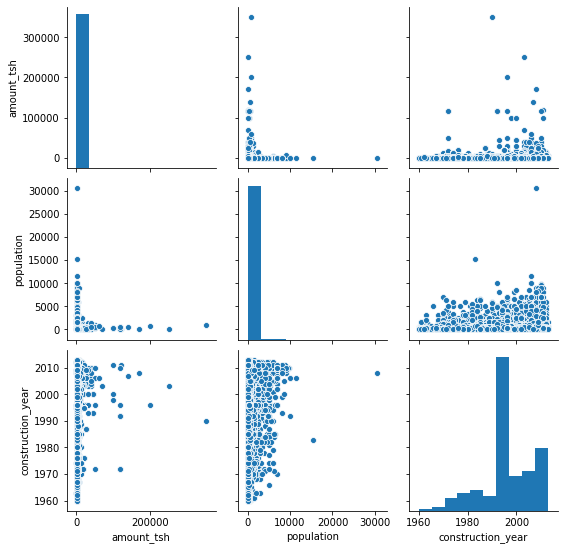

In [20]:
# Exploration of numerical features
numeric = data[["amount_tsh",  "population", "construction_year"]]
sns.pairplot(numeric)

In [21]:
categorical = data.select_dtypes("O").columns
#num_cols = X_train_tf.select_dtypes("number").columns


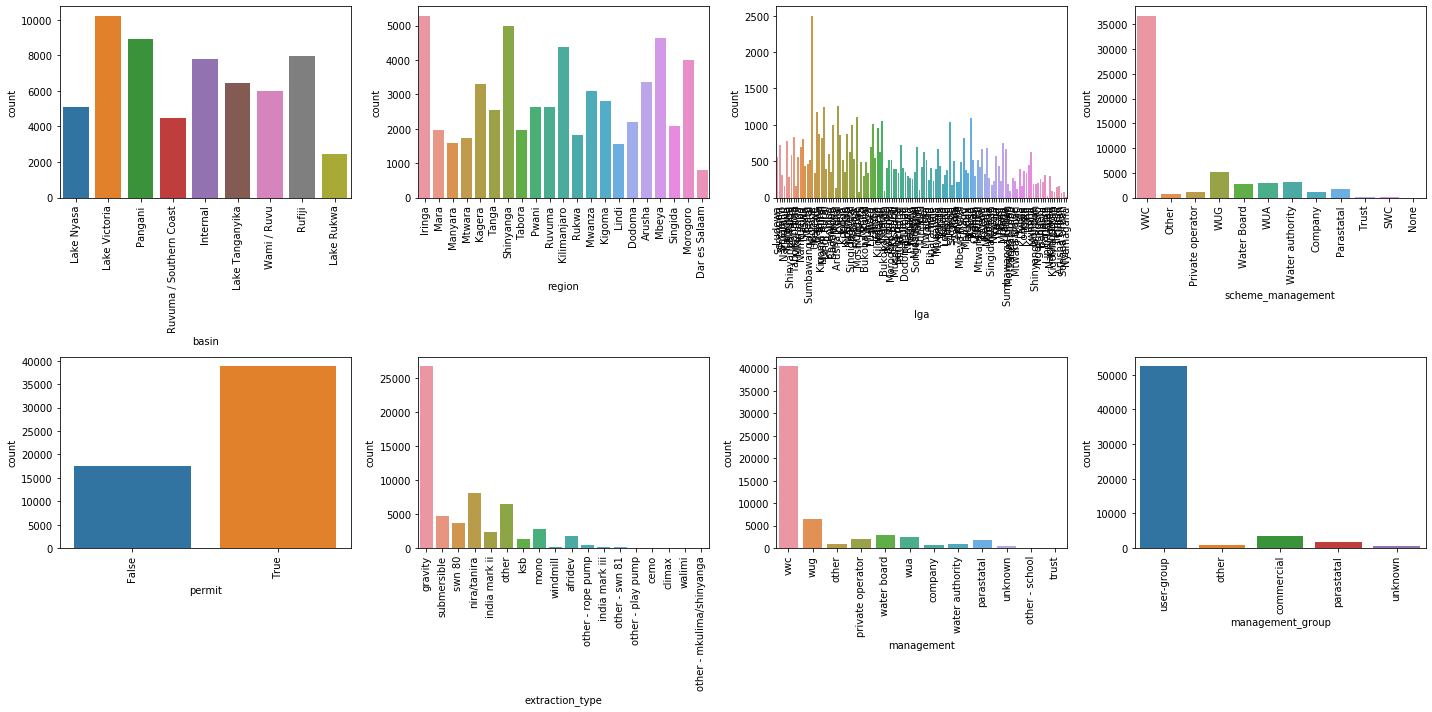

In [22]:
# Exploration of categorical features

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(data[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
        
        
fig.tight_layout()





In [23]:
# Choose the relevant column and apply method value_counts to count the number of appearences of same values
status_group = data['status_group'].value_counts()
status_group =  status_group.sort_values(ascending =True)
#status_group[::-1]

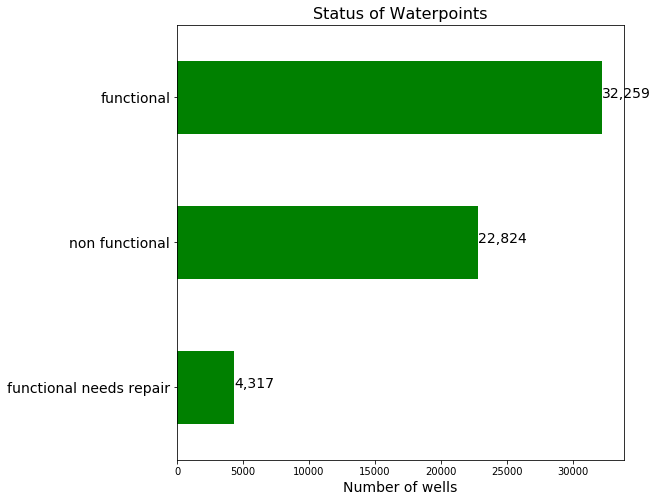

In [24]:
status_group.plot(kind = "barh", figsize = (8,8), color= "green")
plt.xlabel("Number of wells", fontsize = 14)
#plt.ylabel("status group", fontsize = 14)

# annotate value labels to each status
for index,  value in enumerate(status_group):
    label = format(int(value),",")
    

    # place text at the end of bar (subtracting 0.1 from y to make it fit within the bar)
    plt.annotate(label, xy=(value, index-0), color = "black", fontsize =14)
    plt.title("Status of Waterpoints", fontsize= 16)
    plt.yticks(fontsize=14)

There are three different status group possible for each waterpoint: "functional", "functional needs repair" and "non-functional". Here is a count of the number of waterpoints ascribed to each status:


###  Does geographical location affect functionality of the waterpoint?

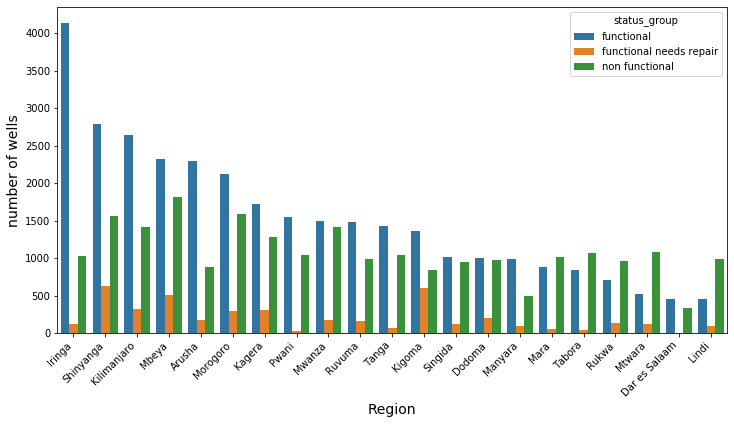

In [25]:
fig, ax = plt.subplots( figsize=(12, 6))
region = data.groupby('status_group').region.value_counts()
w =pd.DataFrame(region.reset_index(name ="count"))

p = sns.barplot(x='region', y='count', hue = 'status_group', data=w)
plt.xlabel("Region", fontsize = 14)
plt.ylabel("number of wells", fontsize = 14)
plt.setp(p.get_xticklabels(), rotation=45, ha="right");

From this analysis we can see that in absolute numbers the regions that have more total number of waterpoints (such as Iringa) are also the ones that have the most amount of non-functional waterpoints. However, because the amount of functional waterpoints in these regions are still higher than the non-functional, they are likely less problematic to the surounding populations. 

###  Does the source of the water contribute for the functionality of the waterpoint?

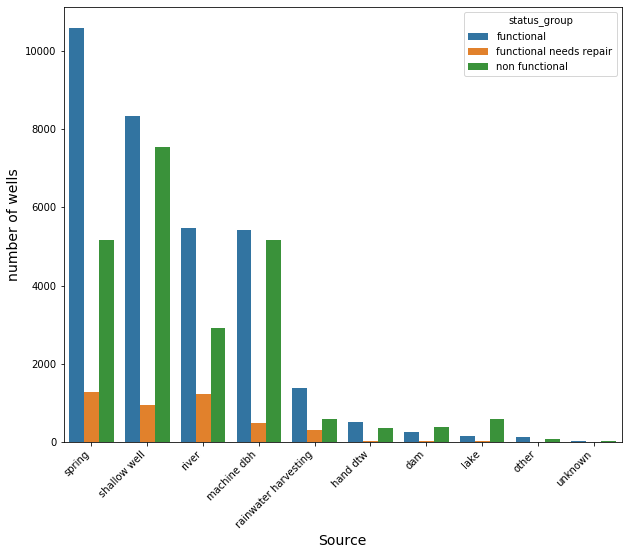

In [26]:
fig, ax = plt.subplots( figsize=(10, 8))
source1 = data.groupby('status_group').source.value_counts()
source =pd.DataFrame(source1.reset_index(name ="count"))
p = sns.barplot(x='source', y='count', hue = 'status_group', data=source)
plt.xlabel("Source", fontsize = 14)
plt.ylabel("number of wells", fontsize = 14)
plt.setp(p.get_xticklabels(), rotation=45, ha="right");

In fact, the source of the water in each waterpoint does seem to affect the status of the waterpoint. For example waterpoints where the water comes from shallow wells or machine dbh have much higher proportions of non-functional waterpoints than waterpoints where the water comes from springs or rivers. 

###  Does the amount of water affect funtionality of the waterpoint?


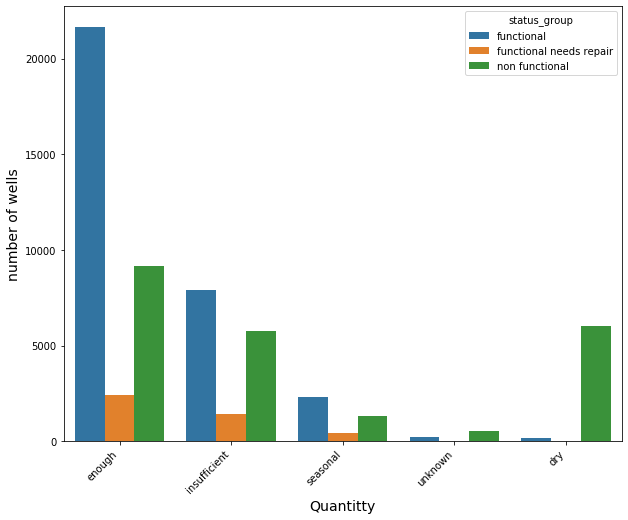

In [27]:
fig, ax = plt.subplots( figsize=(10, 8))
quantity = data.groupby('status_group').quantity.value_counts()
w =pd.DataFrame(quantity.reset_index(name ="count"))

p = sns.barplot(x='quantity', y='count', hue = 'status_group', data=w)
plt.xlabel("Quantitty", fontsize = 14)
plt.ylabel("number of wells", fontsize = 14)
plt.setp(p.get_xticklabels(), rotation=45, ha="right");

The amount of water in each waterpoint also seems to affect the functionality of said waterpoint. Looking at the data is clear that dry waterpoints are largely non-functional, while waterpoints that have sufficient amounts of water have higher proportions of functioning wells. 

###  Does payment-type affect functionality of waterpoints?


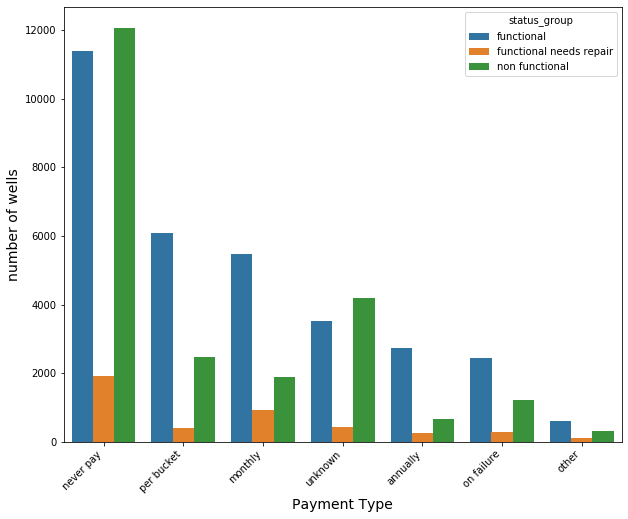

In [28]:
fig, ax = plt.subplots( figsize=(10, 8))
payment_type = data.groupby('status_group').payment_type.value_counts()
w =pd.DataFrame(payment_type.reset_index(name ="count"))

p = sns.barplot(x='payment_type', y='count', hue = 'status_group', data=w)
plt.xlabel("Payment Type", fontsize = 14)
plt.ylabel("number of wells", fontsize = 14)
plt.setp(p.get_xticklabels(), rotation=45, ha="right");

From this exploratory analysis we can see that waterpoints that do not required any type of payment or that do not have information about payment have the highest proportion of wells that are not functional. In contrast, water points that are paid for (independently of the payment method) are generally more functional. This suggests that if the water is paid for there is a higher likelyhood that the waterpoint is better cared for.  


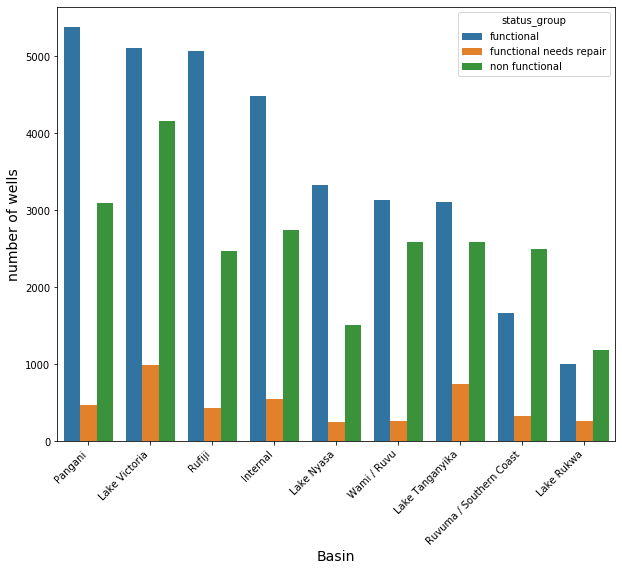

In [29]:
fig, ax = plt.subplots( figsize=(10, 8))
basin = data.groupby('status_group').basin.value_counts()
w =pd.DataFrame(basin.reset_index(name ="count"))

p = sns.barplot(x='basin', y='count', hue = 'status_group', data=w)
plt.xlabel("Basin", fontsize = 14)
plt.ylabel("number of wells", fontsize = 14)
plt.setp(p.get_xticklabels(), rotation=45, ha="right");

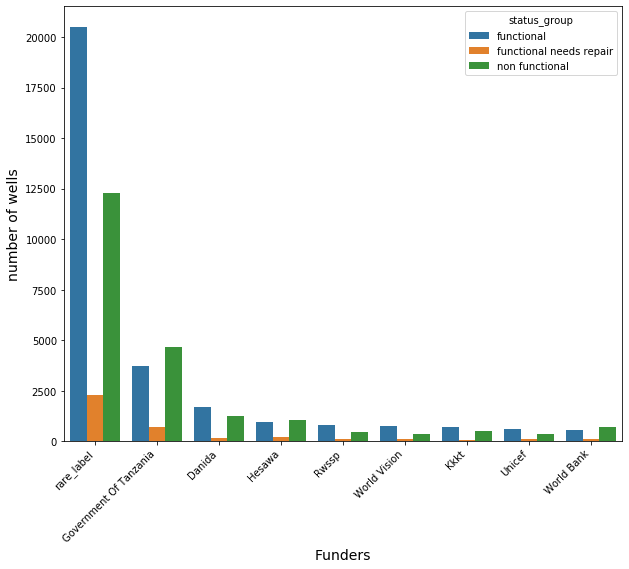

In [30]:
fig, ax = plt.subplots( figsize=(10, 8))
new_fund = data.groupby('status_group').new_fund.value_counts()
w =pd.DataFrame(new_fund.reset_index(name ="count"))

p = sns.barplot(x='new_fund', y='count', hue = 'status_group', data=w)
plt.xlabel("Funders", fontsize = 14)
plt.ylabel("number of wells", fontsize = 14)
plt.setp(p.get_xticklabels(), rotation=45, ha="right");


# V. Data Preparation for Modeling


### Train test split

In preparation to start modeling the data I randomly split the dataframe into data to train my models (80% of the data) and data to test my models (20% of the data).

In [31]:
# separate X and Y 
y = data["status_group"]
X = data.drop("status_group", axis =1)

# Perform test train split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 42)

In [32]:
# Check for null values in training set
X_train.isna().sum()

amount_tsh              0
basin                   0
region                  0
lga                     0
population              0
scheme_management    3102
permit               2439
construction_year       0
extraction_type         0
management              0
management_group        0
payment_type            0
water_quality           0
quantity                0
source                  0
source_class            0
waterpoint_type         0
new_fund             2876
new_installer        2889
dtype: int64

### Filling missing value (simple imputer)

While exploring the data I realized that the categorical features "funder", "installer", "scheme_management" and "permit"contained missing values, which would affect modeling. To address this issue, I used the Sklearn SimpleImputer to replace missing values using "most_frequent" as a strategy. This strategy replaces missing values with the most frequent category in each feature. 

In [33]:
# Import label encoder
from sklearn import preprocessing
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'status_group'.
data['status_group']= label_encoder.fit_transform(data['status_group'])
  
data['status_group'].unique()

#functional =0, functional needs repair =1,non functional = 2              


array([0, 2, 1])

In [34]:
X_train_tf = X_train.copy()
X_test_tf = X_test.copy()

# Most frequent 
mode_col = ["new_fund","new_installer", "scheme_management", "permit"]

#impute the columns with most-frequent value
impute_mode = SimpleImputer(strategy= "most_frequent")
X_train_tf[mode_col] = impute_mode.fit_transform(X_train_tf[mode_col])
X_test_tf[mode_col] = impute_mode.transform(X_test_tf[mode_col])

# check our data
X_train_tf.isna().sum()

amount_tsh           0
basin                0
region               0
lga                  0
population           0
scheme_management    0
permit               0
construction_year    0
extraction_type      0
management           0
management_group     0
payment_type         0
water_quality        0
quantity             0
source               0
source_class         0
waterpoint_type      0
new_fund             0
new_installer        0
dtype: int64

### sparate categorical and numarical

In [35]:
# sparate categorical and numarical
cat_cols = X_train_tf.select_dtypes("O").columns
num_cols = X_train_tf.select_dtypes("number").columns
cat_cols, num_cols

(Index(['basin', 'region', 'lga', 'scheme_management', 'extraction_type',
        'management', 'management_group', 'payment_type', 'water_quality',
        'quantity', 'source', 'source_class', 'waterpoint_type', 'new_fund',
        'new_installer'],
       dtype='object'),
 Index(['amount_tsh', 'population', 'construction_year'], dtype='object'))

#### Categorical

In [36]:
#One Hot Encoder
encoder = OneHotEncoder(sparse=False, handle_unknown = 'ignore') 

train_ohe =  encoder.fit_transform(X_train_tf[cat_cols])
test_ohe = encoder.transform(X_test_tf[cat_cols])
train_ohe

array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [37]:
train_ohe_cat = pd.DataFrame(train_ohe, columns = encoder.get_feature_names(cat_cols))
test_ohe_cat = pd.DataFrame(test_ohe, columns = encoder.get_feature_names(cat_cols))
train_ohe_cat

basin_Internal  basin_Lake Nyasa  basin_Lake Rukwa  \
0                 1.0               0.0               0.0   
1                 1.0               0.0               0.0   
2                 0.0               0.0               1.0   
3                 0.0               0.0               0.0   
4                 0.0               0.0               0.0   
...               ...               ...               ...   
47515             0.0               0.0               0.0   
47516             0.0               1.0               0.0   
47517             0.0               0.0               0.0   
47518             0.0               0.0               0.0   
47519             0.0               0.0               0.0   

       basin_Lake Tanganyika  basin_Lake Victoria  basin_Pangani  \
0                        0.0                  0.0            0.0   
1                        0.0                  0.0            0.0   
2                        0.0                  0.0            0.0   
3                        0.0                  0.0            0.0   
4                        0.0                  0.0            0.0   
...                      ...                  ...            ...   
47515                    0.0                  0.0            0.0   
47516                    0.0                  0.0            0.0   
47517                    0.0                  0.0            1.0   
47518                    0.0                  1.0            0.0   
47519                    0.0                  0.0            1.0   

       basin_Rufiji  basin_Ruvuma / Southern Coast  basin_Wami / Ruvu  \
0               0.0                            0.0                0.0   
1               0.0                            0.0                0.0   
2               0.0                            0.0                0.0   
3               1.0                            0.0                0.0   
4               0.0                            0.0                1.0   
...             ...                            ...                ...   
47515           1.0                            0.0                0.0   
47516           0.0                            0.0                0.0   
47517           0.0                            0.0                0.0   
47518           0.0                            0.0                0.0   
47519           0.0                            0.0                0.0   

       region_Arusha  ...  new_installer_DANIDA  new_installer_DWE  \
0                0.0  ...                   0.0                0.0   
1                0.0  ...                   0.0                0.0   
2                0.0  ...                   0.0                0.0   
3                0.0  ...                   0.0                0.0   
4                0.0  ...                   0.0                0.0   
...              ...  ...                   ...                ...   
47515            0.0  ...                   0.0                1.0   
47516            0.0  ...                   0.0                0.0   
47517            0.0  ...                   0.0                0.0   
47518            0.0  ...                   0.0                0.0   
47519            0.0  ...                   0.0                0.0   

       new_installer_District Council  new_installer_Government  \
0                                 0.0                       0.0   
1                                 0.0                       0.0   
2                                 0.0                       0.0   
3                                 0.0                       0.0   
4                                 0.0                       0.0   
...                               ...                       ...   
47515                             0.0                       0.0   
47516                             0.0                       0.0   
47517                             0.0                       0.0   
47518                             0.0                       0.0   
47

#### Numerical

In [38]:
# scaling number 
scaler = StandardScaler()
train_ohe_num = pd.DataFrame(scaler.fit_transform(X_train_tf[num_cols]),
                            columns = num_cols)
test_ohe_num = pd.DataFrame(scaler.transform(X_test_tf[num_cols]),
                           columns = num_cols)


### Combine data

In [39]:
#combine number and categorical features
X_train_tf = pd.concat([train_ohe_cat, train_ohe_num], axis = 1)
X_test_tf = pd.concat([test_ohe_cat, test_ohe_num], axis = 1)
X_train_tf

basin_Internal  basin_Lake Nyasa  basin_Lake Rukwa  \
0                 1.0               0.0               0.0   
1                 1.0               0.0               0.0   
2                 0.0               0.0               1.0   
3                 0.0               0.0               0.0   
4                 0.0               0.0               0.0   
...               ...               ...               ...   
47515             0.0               0.0               0.0   
47516             0.0               1.0               0.0   
47517             0.0               0.0               0.0   
47518             0.0               0.0               0.0   
47519             0.0               0.0               0.0   

       basin_Lake Tanganyika  basin_Lake Victoria  basin_Pangani  \
0                        0.0                  0.0            0.0   
1                        0.0                  0.0            0.0   
2                        0.0                  0.0            0.0   
3                        0.0                  0.0            0.0   
4                        0.0                  0.0            0.0   
...                      ...                  ...            ...   
47515                    0.0                  0.0            0.0   
47516                    0.0                  0.0            0.0   
47517                    0.0                  0.0            1.0   
47518                    0.0                  1.0            0.0   
47519                    0.0                  0.0            1.0   

       basin_Rufiji  basin_Ruvuma / Southern Coast  basin_Wami / Ruvu  \
0               0.0                            0.0                0.0   
1               0.0                            0.0                0.0   
2               0.0                            0.0                0.0   
3               1.0                            0.0                0.0   
4               0.0                            0.0                1.0   
...             ...                            ...                ...   
47515           1.0                            0.0                0.0   
47516           0.0                            0.0                0.0   
47517           0.0                            0.0                0.0   
47518           0.0                            0.0                0.0   
47519           0.0                            0.0                0.0   

       region_Arusha  ...  new_installer_Government  new_installer_HESAWA  \
0                0.0  ...                       0.0                   0.0   
1                0.0  ...                       0.0                   0.0   
2                0.0  ...                       0.0                   0.0   
3                0.0  ...                       0.0                   0.0   
4                0.0  ...                       0.0                   0.0   
...              ...  ...                       ...                   ...   
47515            0.0  ...                       0.0                   0.0   
47516            0.0  ...                       0.0                   0.0   
47517            0.0  ...                       0.0                   0.0   
47518            0.0  ...                       0.0                   0.0   
47519            0.0  ...                       0.0                   0.0   

       new_installer_Hesawa  new_installer_KKKT  new_installer_RWE  \
0                       0.0                 0.0                0.0   
1                       0.0                 0.0                0.0   
2                       0.0                 1.0                0.0   
3                       0.0                 0.0                0.0   
4                       0.0                 0.0                0.0   
...                     ...                 ...                ...   
47515                   0.0                 0.0                0.0   
47516                   0.0                 0.0                0.0   
47517                   0

### evalation

In [40]:

def evalation(model):

    ## Check the .score of the model
    print(model.score(X_train_tf,y_train))
    print("****************************************")
    ## Get the model's .score for training and test set 
    print(f"Training Score:\t{model.score(X_train_tf,y_train):.2f}")
    print(f"Test Score:\t{model.score(X_test_tf,y_test):.2f}")

    print("****************************************")

    ## Get Predictions for training and test data to check metrics functions
    y_hat_train = model.predict(X_train_tf)
    y_hat_test = model.predict(X_test_tf)

    ## is it r-squared?
    #print(metrics.r2_score(y_train,y_hat_train))
    print("****************************************")
    ## Try root_mean_square_error
    #print(metrics.mean_squared_error(y_train,y_hat_train,squared=False))
    print("****************************************")
    # Use metrics.plot_confusion_matrix
    metrics.plot_confusion_matrix(model, X_test_tf,y_test,cmap='Blues',xticks_rotation='vertical',normalize='true',
                                display_labels=['functional', 'functional needs repair' ,'non functional'])

    #metrics.plot_confusion_matrix(model, X_test_tf,y_test,cmap='Blues',normalize='true')

    print(metrics.classification_report(y_test,y_hat_test))
    

# Modeling

## Dummy Classifier

Because developing machine learning models rely on multiple attempts to increase the success rate of classification tasks, evaluating the baseline success rate is an important step to take. We can do this using the Dummy Classifier, which sets the baseline performance (i.e. the success rate that one should expect to achive by simply guessing). 


0.44511784511784513
****************************************
Training Score:	0.45
Test Score:	0.45
****************************************
****************************************
****************************************
                         precision    recall  f1-score   support

             functional       0.54      0.54      0.54      6457
functional needs repair       0.07      0.08      0.07       851
         non functional       0.38      0.38      0.38      4572

               accuracy                           0.45     11880
              macro avg       0.33      0.33      0.33     11880
           weighted avg       0.45      0.45      0.45     11880



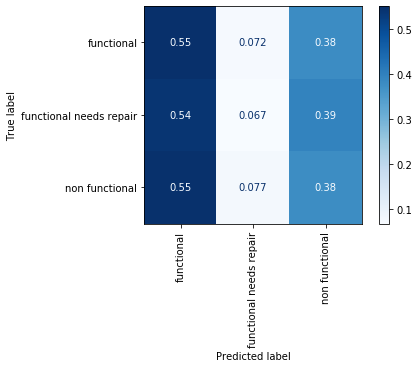

In [41]:

## Make and fit  dummy classifier
model = DummyClassifier(strategy='stratified')
model.fit(X_train_tf,y_train)
evalation(model)

Looking at the this model we now know that our training and test score  baseline is 0.45 and accuracy is 0.44. Looking at the confusion matrice we can see that at baseline we can predict 54% of the functional, 5.9% of the functional need repair and 38% of the non-functional waterpoints. 

In [42]:
def features_importans(model):
    
    fig, ax = plt.subplots( figsize=(10, 8))
    imp_feats = pd.DataFrame(data = model.feature_importances_,
                             index = X_train_tf.columns,
                             columns = ["Feat imp"])


    imp_feats = imp_feats.sort_values("Feat imp", ascending=False)
    imp_feat = imp_feats[imp_feats["Feat imp"]>0]
    imp_feat1 = imp_feat.head(30)
    print(imp_feat1)

    sns.barplot(data = imp_feat1, x = imp_feat1.index, y="Feat imp")
    plt.ylabel("Features Importance", fontsize =14)
    plt.xticks(rotation = 90,fontsize=14);
    
    

## Decision Tree Classifier

The Decision Tree algorithm sets a sequential, hierarchical decisions. The goal of using a Decision Tree is to create a training model that can be used to predict the class or value of the target variable by learning simple decision rules inferred from prior data. 


0.9220749158249159
****************************************
Training Score:	0.92
Test Score:	0.76
****************************************
****************************************
****************************************
                         precision    recall  f1-score   support

             functional       0.78      0.84      0.81      6457
functional needs repair       0.40      0.35      0.37       851
         non functional       0.79      0.73      0.76      4572

               accuracy                           0.76     11880
              macro avg       0.66      0.64      0.65     11880
           weighted avg       0.76      0.76      0.76     11880



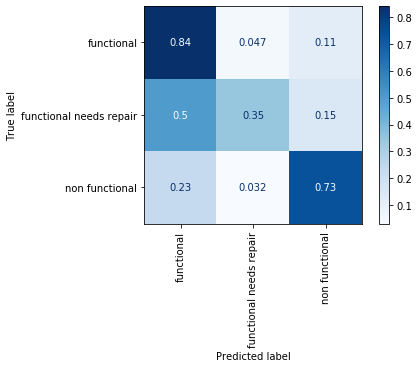

In [43]:
#I started by making a decision tree with the default parameters

from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()

"""dt_param_grid = {"criterion": ['gini'],
                "max_depth": [10],
                "max_features": ['auto'],
                "random_state": [1],
                "splitter": ['best']}"""


decision_tree.fit(X_train_tf,y_train)
evalation(decision_tree)


Looking at this model, we can see that our training (0.92) and test score (0.76), as well as the accurary (0.76), increased considerably from the baseline determined by using the Dummy Classifier. We are now able to accuratly predict 84% of the functional, 34% of the functional need repair and 73% of the non-functional waterpoints. However, the training score and the test scores are considerably far apart which tells us that this model is overfitting data.


To get a sense into what features are giving the most importance in the decision tree, I calculated the feature importance of this model.

                                             Feat imp
quantity_dry                                 0.160887
population                                   0.118959
construction_year                            0.095938
waterpoint_type_other                        0.082430
amount_tsh                                   0.024912
payment_type_never pay                       0.019258
waterpoint_type_communal standpipe multiple  0.018985
new_fund_rare_label                          0.012979
quantity_enough                              0.012218
quantity_insufficient                        0.011631
region_Iringa                                0.010404
extraction_type_gravity                      0.009106
new_installer_DWE                            0.008975
payment_type_unknown                         0.008519
source_shallow well                          0.007441
new_installer_rare_label                     0.007272
lga_Bariadi                                  0.006961
water_quality_soft          

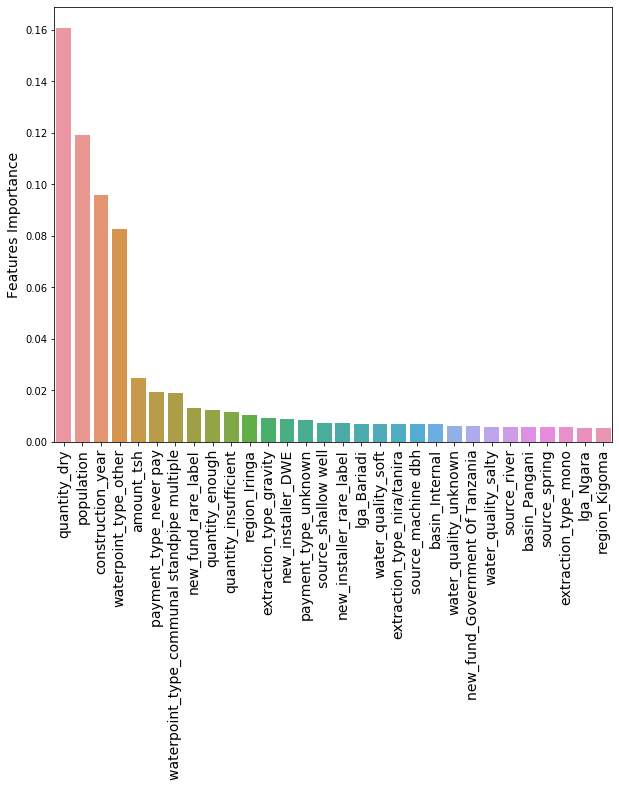

In [44]:
features_importans(decision_tree)

For this decision tree model the features that have the most importance are quantity of water (specially if it is dry), population around the waterpoint and how old the waterpoint is (construction year).

An important feature of modeling using decision trees is the depth (lenght of the longest path from a root to a leaf) of the decision tree. This is because the deeper the tree the more difficult it becomes to understand the decision rules of a tree. Since the default decision tree model was overfitted, I tried two different depths to see if it improves the predictive power of the model.


0.9220749158249159
****************************************
Training Score:	0.92
Test Score:	0.76
****************************************
****************************************
****************************************
                         precision    recall  f1-score   support

             functional       0.78      0.84      0.81      6457
functional needs repair       0.38      0.32      0.35       851
         non functional       0.79      0.73      0.76      4572

               accuracy                           0.76     11880
              macro avg       0.65      0.63      0.64     11880
           weighted avg       0.75      0.76      0.76     11880



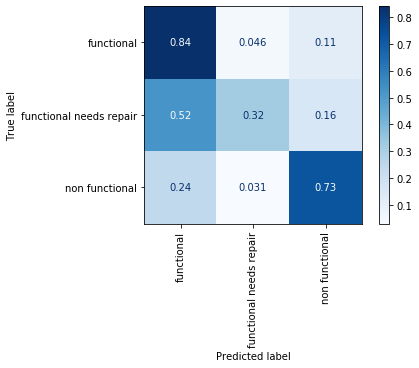

In [45]:
#In this model I assigned the depth of the tree to a maximum of 100.
dt = DecisionTreeClassifier()


dt_param_grid = {"criterion": ['gini', "entropy"],
                "max_depth": [100],
                "max_features": ['auto'],
                "random_state": [1],
                "splitter": ['best']}


grid_dt = GridSearchCV(dt, dt_param_grid, scoring='accuracy', cv=10, n_jobs=-1)
grid_dt.fit(X_train_tf, y_train)

evalation(grid_dt)

0.7992213804713805
****************************************
Training Score:	0.80
Test Score:	0.75
****************************************
****************************************
****************************************
                         precision    recall  f1-score   support

             functional       0.73      0.91      0.81      6457
functional needs repair       0.49      0.20      0.29       851
         non functional       0.83      0.63      0.72      4572

               accuracy                           0.75     11880
              macro avg       0.68      0.58      0.60     11880
           weighted avg       0.75      0.75      0.74     11880



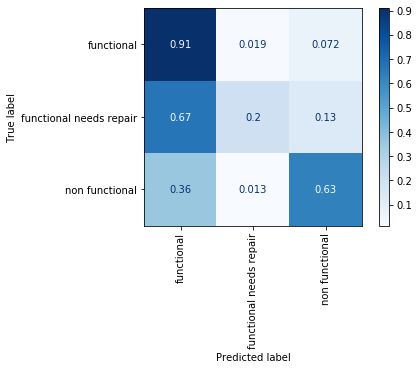

In [46]:
#In this model I assigned the depth of the tree to a maximum of 20.
dt = DecisionTreeClassifier()

dt_param_grid = {"criterion": ['gini', "entropy"],
                "max_depth": [20],
                "max_features": ['auto'],
                "random_state": [1],
                "splitter": ['best']}


grid_dt = GridSearchCV(dt, dt_param_grid, scoring='accuracy', cv=10, n_jobs=-1)
grid_dt.fit(X_train_tf, y_train)

evalation(grid_dt)

Finaly I decided to reduce the depth of the tree to 10 to see if it would give me a better fitted model.

0.7214225589225589
****************************************
Training Score:	0.72
Test Score:	0.71
****************************************
****************************************
****************************************
                         precision    recall  f1-score   support

             functional       0.69      0.91      0.78      6457
functional needs repair       0.54      0.09      0.15       851
         non functional       0.78      0.55      0.64      4572

               accuracy                           0.71     11880
              macro avg       0.67      0.51      0.53     11880
           weighted avg       0.71      0.71      0.68     11880



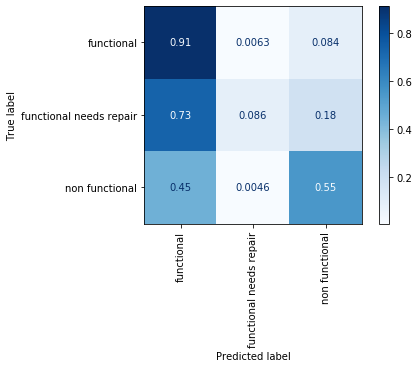

In [47]:
dt = DecisionTreeClassifier()

dt_param_grid = {"criterion": ['gini', "entropy"],
                "max_depth": [10],
                "max_features": ['auto'],
                "random_state": [1],
                "splitter": ['best']}


grid_dt = GridSearchCV(dt, dt_param_grid, scoring='accuracy', cv=10, n_jobs=-1)
grid_dt.fit(X_train_tf, y_train)

evalation(grid_dt)

# Random Forest Classifier

Random Forest is a tree-based  algorithm that leverages the power of multiple decision trees for making decisions. Because often a a single tree is not sufficient for producing effective results, and my decision tree models could definitly be improved, I decided to also use the Random Forest algorithm to see if it would improve the predictive power of the model. 

0.922053872053872
****************************************
Training Score:	0.92
Test Score:	0.79
****************************************
****************************************
****************************************
                         precision    recall  f1-score   support

             functional       0.79      0.87      0.83      6457
functional needs repair       0.48      0.31      0.38       851
         non functional       0.82      0.76      0.79      4572

               accuracy                           0.79     11880
              macro avg       0.70      0.65      0.67     11880
           weighted avg       0.78      0.79      0.78     11880



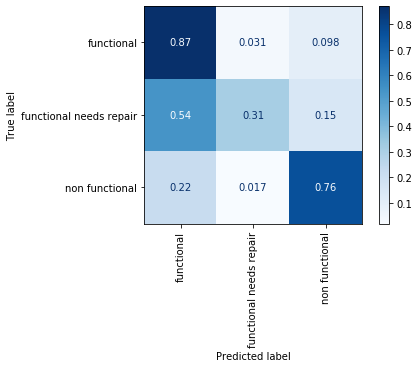

In [48]:
rf= RandomForestClassifier()
rf.fit(X_train_tf, y_train)
evalation(rf)

The model given by the default random forest still needs to be improved as it is overfitted. Because Random Forest is a collection of decision trees, the number of trees built in the model will affect the prediction. Thus, decided to change the number of trees (n-estimators) used in the model.

                                             Feat imp
population                                   0.120307
construction_year                            0.094946
quantity_dry                                 0.083341
quantity_enough                              0.036262
waterpoint_type_other                        0.033056
amount_tsh                                   0.032003
extraction_type_other                        0.028473
quantity_insufficient                        0.019945
payment_type_never pay                       0.016669
waterpoint_type_communal standpipe           0.013775
new_fund_rare_label                          0.012520
new_installer_rare_label                     0.012002
extraction_type_gravity                      0.011099
new_installer_DWE                            0.010862
water_quality_soft                           0.010149
waterpoint_type_communal standpipe multiple  0.010082
waterpoint_type_hand pump                    0.010006
extraction_type_nira/tanira 

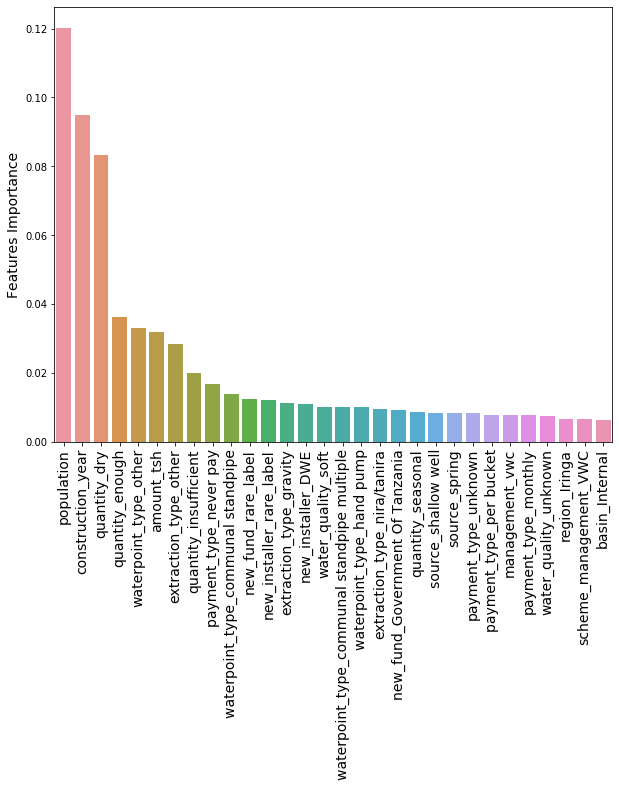

In [49]:
features_importans(rf)

0.8464856902356902
****************************************
Training Score:	0.85
Test Score:	0.80
****************************************
****************************************
****************************************
                         precision    recall  f1-score   support

             functional       0.78      0.92      0.84      6457
functional needs repair       0.63      0.23      0.34       851
         non functional       0.85      0.74      0.79      4572

               accuracy                           0.80     11880
              macro avg       0.75      0.63      0.66     11880
           weighted avg       0.79      0.80      0.78     11880



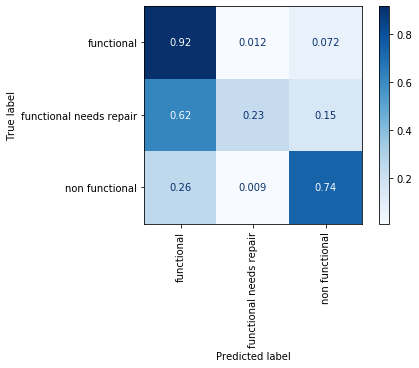

In [50]:
#n_estimators=1000

rf1= RandomForestClassifier(n_estimators=1000, criterion='gini', 
                                max_depth=None, min_samples_split=2, min_samples_leaf=2)
rf1.fit(X_train_tf, y_train)
evalation(rf1)

Using 1000 estimators this model now shows a training score that is a bit lower than the previou model (0.85). However the test score is now 0.8 with accuracy also at 0.8. Meaning that this is a decently fitted and accurate model. The confusion matrice shows that it can accuratly  predict 92% of the functional waterpoints, 23% of the functional need repair and 74% of the non-functional. This model therefore seems to be the best model that I have developed so far. 

0.7494949494949495
****************************************
Training Score:	0.75
Test Score:	0.75
****************************************
****************************************
****************************************
                         precision    recall  f1-score   support

             functional       0.70      0.96      0.81      6457
functional needs repair       0.60      0.04      0.07       851
         non functional       0.89      0.57      0.70      4572

               accuracy                           0.75     11880
              macro avg       0.73      0.52      0.53     11880
           weighted avg       0.76      0.75      0.71     11880



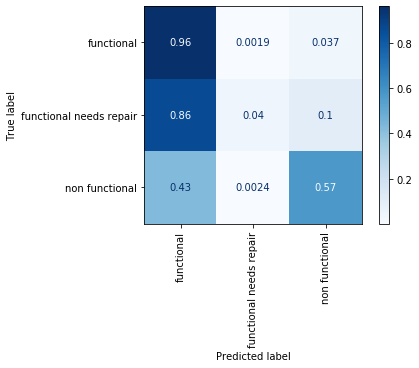

In [51]:
rf= RandomForestClassifier()

rf_param_grid={'n_estimators' : [1000], 
                'criterion' : ['gini','entropy'], 
                'max_depth': [10],
                'min_samples_split' : [10], 
                'min_samples_leaf' : [5]
              }

"""rf_param_grid = {
    'n_estimators': [10,  100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None,  6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
    
}"""

grid_dt = GridSearchCV(rf, rf_param_grid,scoring='accuracy', cv=10, n_jobs=-1)
grid_dt.fit(X_train_tf, y_train)

evalation(grid_dt)

# K-Nearest Neighbor Classifier

The KNN algorithm uses a different underlying principle than decision trees and random forest classifiers. KNN captures the idea of similarity (also called proximity) of the data points. Because KNN uses a different principle I thought it would be a good idea to see if a KNN model would be a better predictor. The key askpect of the KNN classifier is how many neighbors (K) to use in the analysis. 

0.8006313131313131
****************************************
Training Score:	0.80
Test Score:	0.77
****************************************
****************************************
****************************************
                         precision    recall  f1-score   support

             functional       0.76      0.89      0.82      6457
functional needs repair       0.53      0.26      0.35       851
         non functional       0.81      0.69      0.75      4572

               accuracy                           0.77     11880
              macro avg       0.70      0.61      0.64     11880
           weighted avg       0.76      0.77      0.76     11880



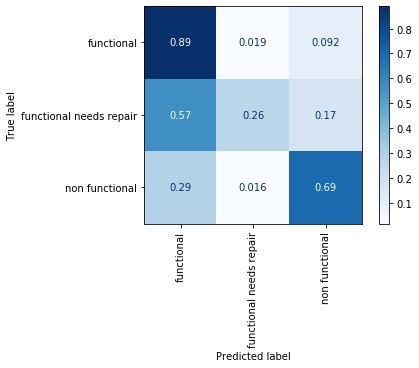

In [52]:
# K-Nearest Neighbor with K= 10
knn =  KNeighborsClassifier(n_neighbors =10)
knn.fit(X_train_tf, y_train)
evalation(knn)

Increasinh K to 17 seems to have made the model better fitted, with a training score of 0.78 and a test score of 0.77. It retains accurary (0.77) and is able to predict the same data as the model with K=10.

0.7840909090909091
****************************************
Training Score:	0.78
Test Score:	0.77
****************************************
****************************************
****************************************
                         precision    recall  f1-score   support

             functional       0.76      0.89      0.82      6457
functional needs repair       0.53      0.23      0.32       851
         non functional       0.81      0.69      0.74      4572

               accuracy                           0.77     11880
              macro avg       0.70      0.60      0.63     11880
           weighted avg       0.76      0.77      0.75     11880



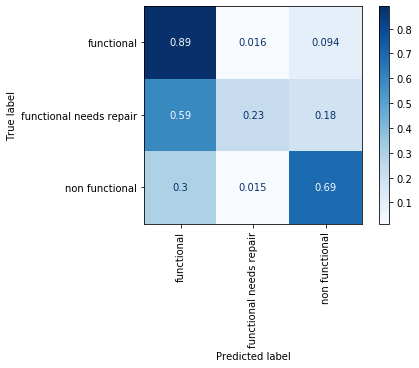

In [53]:
#K-Nearest Neighbor with K=17
knn =  KNeighborsClassifier(n_neighbors =17)
knn.fit(X_train_tf, y_train)
evalation(knn)

Increasinh K to 17 seems to have made the model better fitted, with a training score of 0.78 and a test score of 0.77. It retains accurary (0.77) and is able to predict the same data as the model with K=10. 

0.7535353535353535
****************************************
Training Score:	0.75
Test Score:	0.75
****************************************
****************************************
****************************************
                         precision    recall  f1-score   support

             functional       0.73      0.90      0.81      6457
functional needs repair       0.60      0.17      0.27       851
         non functional       0.80      0.64      0.71      4572

               accuracy                           0.75     11880
              macro avg       0.71      0.57      0.59     11880
           weighted avg       0.75      0.75      0.73     11880

Testing Accuracy: 74.14%

Optimal Parameters: {'metric': 'manhattan', 'n_neighbors': 50, 'weights': 'uniform'}


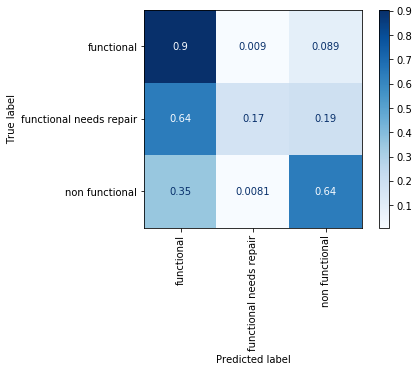

In [54]:
#K-Nearest Neighbor with K=50
knn =  KNeighborsClassifier()

knn_param_grid ={"n_neighbors":[50],
                "weights": ["uniform"],
                "metric":["euclidean","manhattan"]}
                                    
                                    
grid_knn = GridSearchCV(knn, knn_param_grid, scoring='accuracy', cv=10, n_jobs=-1)
grid_knn.fit(X_train_tf, y_train)

evalation(grid_knn)   
        
print(f"Testing Accuracy: {grid_knn.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {grid_knn.best_params_}")

This model is better fitted than the previous model with both the training and test score = to 0.75 and accuracy = 0.75. It can predict 90% of the functional, 17% of the functional needs repair and 63% of the non-functional waterpoints.

# smote

After trying all the different models shown above, I was puzzled as to why the functional need repair class is much harder to predict than the other two classes. By looking at the total number of waterpoints in each of these status classes (shown above) we can see that the amount of data for functional need repair is significantly lower than either funtional or non-functional and therefore is causing bias in the models. This is a problem because most machine learning techniques, such as the ones used so far, will ignore the minority class and in turn have poor performance on said class. To try to make the model less biased, I decided to oversample the functional need repair class using the SMOTE technique. This technique duplicates the data in the minority class such that it increases the amount of data in this class without adding any new information to the model.

In [55]:
# Dealing with Class Imbalance
from imblearn.over_sampling import SMOTE

#Compare previous and resampled target counts
#Print imbalanced target
print(data['status_group'].value_counts())

#SMOTE to balance the data
X_SMOTE, y_SMOTE = SMOTE().fit_sample(X_train_tf, y_train)

#Print balanced target
print(pd.Series(y_SMOTE).value_counts())

0    32259
2    22824
1     4317
Name: status_group, dtype: int64
non functional             25802
functional                 25802
functional needs repair    25802
Name: status_group, dtype: int64


0.7309974747474748
****************************************
Training Score:	0.73
Test Score:	0.69
****************************************
****************************************
****************************************
                         precision    recall  f1-score   support

             functional       0.82      0.68      0.74      6457
functional needs repair       0.24      0.69      0.35       851
         non functional       0.78      0.70      0.74      4572

               accuracy                           0.69     11880
              macro avg       0.61      0.69      0.61     11880
           weighted avg       0.77      0.69      0.71     11880



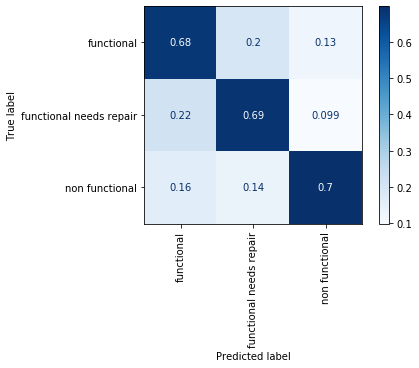

In [56]:
#K-Nearest Neighbor with K=17
knn =  KNeighborsClassifier(n_neighbors =17)
knn.fit(X_SMOTE, y_SMOTE)
evalation(knn)

Just like what happened with Random Forest, the KNN model done on data balanced with SMOTE resulted in a model that is not as well fitted (testing score = 0.73 and test score = 0.68) nor as accurate (0.68 accuracy) as the native model. This model can accuratly predict more functional need repair waterpoints than any of the other models (71%), however it predicts less of the functional (68%) and non-functional (69%)waterpoints, thus resulting in less data accuratly predicted overall.

0.8367424242424243
****************************************
Training Score:	0.84
Test Score:	0.77
****************************************
****************************************
****************************************
                         precision    recall  f1-score   support

             functional       0.82      0.80      0.81      6457
functional needs repair       0.34      0.58      0.43       851
         non functional       0.83      0.76      0.79      4572

               accuracy                           0.77     11880
              macro avg       0.66      0.71      0.68     11880
           weighted avg       0.79      0.77      0.78     11880



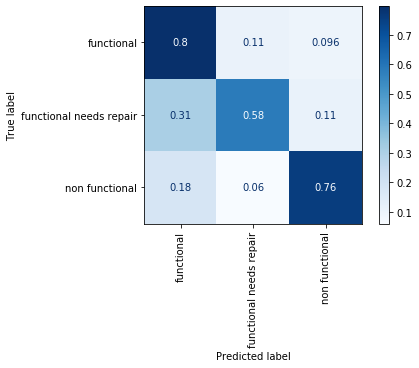

In [57]:
#n_estimators=1000
rf= RandomForestClassifier(n_estimators=1000, criterion='gini', 
                                max_depth=None, min_samples_split=2, min_samples_leaf=2)
rf.fit(X_SMOTE, y_SMOTE)
evalation(rf)

Using data balanced with SMOTE I ran the same model as above (random forest model with 1000 estimators) to see if my model would get better. The model made from the data balanced with SMOTE can now predict 80% of functional, 58% of functional need repair and 76% of non-functional waterpoints. This is a big improvement on the ability to predict the functional need repair waterpoints. However, it is not as well fitted as the same model working on the native data with a training score of 0.84 and a test score of 0.77 and it is also less accurate (0.77). Importantly, because the absolute number of waterpoints in the functional need repair is so much smaller than in the other two classes this increase in ability to predict functional needs repair waterpoints alone does not make this a better model as it accuratly predicts less waterpoints than the model above done without SMOTE. 

# Model Analysis and Conclusions

I have used three different classifiers to try to accuratly predict the status of waterpoints in Tanzania. Below is a summary of how the best model in each classifier performed in the testing data:

* Decision Tree Classifier: 0.71

* Random Forest Classifier: 0.80

* K-Nearest Neighbor Classifier: 0.77


Looking at all the information provided by these different models, I believe that the best model that I have so far is the Random Forest Classifier (with 1000 estimators). 

When looking at the Confusion Matrices from each model it is clear that there is a certain degree of bias in the models. While these models can predict with some degree of confidence the functional and non-functional waterpoints, the waterpoints that are functional but in need of repair are harder to predict. This seems to be caused by the fact that there is a great imbalance in the abundance of data from waterpoints that are function and need repair used to train. Although I tried to deal with this disproportion using SMOTE and successfully reduced the bias of the models, it resulted in overall lower scores and the ability of predicting accuratly less number waterpoints. Additional work will need to be done to better deal with the bias introduced by the low abundance of functional need repair waterpoints to create a model that accuratly can predict the functionality of waterpoints in Tanzania. Moreover, performing hyperparameter tunings can also help with making the models more acurate. 

Importantly from the analyses of some of these decision tree-based models we can infer the importance of each feature in the model which then gives a sense of what features might be key to the functionality of the waterpoints in Tanzania. Looking at these, it seems that the quantity of water available in each waterpoints, particularly if they are dry, the population around each waterpoint and the how old the waterpoints is are the most significant to predict the functionality of waterpoints in Tanzania. 



